# **2nd PIVA Person Segmentation Challenge (PPSC-2024)**

**G11 - E08**

**Marina Grifell, Ignacio Gris and Aïda Santacreu**

***Note: All trainings have not been executed here. We will just leave the code.***

## **0. Install required dependencies and repositories**

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
%cd /content

/content


In [ ]:
!pip install ultralytics
!pip install clearml
!pip install -U ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.6/779.6 kB 6.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
from ultralytics import YOLO
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch.nn.functional as F
import numpy as np
import torch
import os
import clearml
import shutil
import cv2

## **1. Data preprocessing**

In this section we will perform all necessary transformation in order to go from the original data that has been given to some data information that can be processed by YOLO's model. This is, we cannot use the mask images. We need to generate some labels in a specific format that can be processed by the model. We will be specifying and explaining all necessary transformations that have been done.

### **1.1. Downloading the data from Google Drive**

All the downloaded data is going to be already splitted, so here we will place the code that has been used to split the data.

In [ ]:
# Define paths
base_dir = '/content/data_train_competition_raw'
images_dir = os.path.join(base_dir, 'images', 'train')
masks_dir = os.path.join(base_dir, 'masks_pre', 'train')

# Define destination directories
train_images_dir = os.path.join(base_dir, 'images', 'train_split')
val_images_dir = os.path.join(base_dir, 'images', 'val_split')
test_images_dir = os.path.join(base_dir, 'images', 'test_split')

train_masks_dir = os.path.join(base_dir, 'masks_pre', 'train_split')
val_masks_dir = os.path.join(base_dir, 'masks_pre', 'val_split')
test_masks_dir = os.path.join(base_dir, 'masks_pre', 'test_split')

# Create destination directories if they don't exist
os.makedirs(train_images_dir, exist_ok=True)
os.makedirs(val_images_dir, exist_ok=True)
os.makedirs(test_images_dir, exist_ok=True)

os.makedirs(train_masks_dir, exist_ok=True)
os.makedirs(val_masks_dir, exist_ok=True)
os.makedirs(test_masks_dir, exist_ok=True)

# List all samples
samples = os.listdir(images_dir)

# Shuffle the samples
random.shuffle(samples)

# Define split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Calculate split indices
num_samples = len(samples)
train_end = int(train_ratio * num_samples)
val_end = train_end + int(val_ratio * num_samples)

# Split samples
train_samples = samples[:train_end]
val_samples = samples[train_end:val_end]
test_samples = samples[val_end:]

def copy_files(sample_list, src_images_dir, src_masks_dir, dest_images_dir, dest_masks_dir):
    for sample in sample_list:
        # Copy image file
        src_image_path = os.path.join(src_images_dir, sample)
        dest_image_path = os.path.join(dest_images_dir, sample)
        shutil.copyfile(src_image_path, dest_image_path)

        # Copy mask file (assuming the mask file has the same name as the image file)
        sample_mask = sample.replace('jpg', 'png')

        src_mask_path = os.path.join(src_masks_dir, sample_mask)
        dest_mask_path = os.path.join(dest_masks_dir, sample_mask)
        shutil.copyfile(src_mask_path, dest_mask_path)

# Copy files to respective directories
copy_files(train_samples, images_dir, masks_dir, train_images_dir, train_masks_dir)
copy_files(val_samples, images_dir, masks_dir, val_images_dir, val_masks_dir)
copy_files(test_samples, images_dir, masks_dir, test_images_dir, test_masks_dir)

print("Dataset split into train, validation, and test sets successfully.")


First of all we need to unzip the data we have stored in our Google Drive account as a zip file.

In [ ]:
!unzip -q "/content/drive/MyDrive/PPSC-2024/Data/data_train_competition.zip" -d "/content/"

At this moment we will have all the data downloaded, not only the oringinal one. In this folder we have two kind of masks, the images and the labels.



1.   **Images**: These are the original images of the dataset, which have been expanded with the PennFudan Dataset images given in the assignment's statement.
2.   **Masks_Pre**: These are the original masks that are given in the dataset, which have been expanded with the PennFudan Dataset masks given in the assignment's statement.
3.   **Masks_Post**: These are the processed masks. In the original masks we have just values 0 for the background and 1-255 (one for each detected person) for the people. However, in greyscale, as there are normally no more than 10 people in an image, these values are almost black. In order to create the labels, we need to process the masks to make the contours noticeable.
4.   **Labels**: These are the data files that will be passed to YOLO in order to check predictions.



This is because all preprocessing has been done locally or in a Kaggle environment. However, we will include the processing steps as well, which could be also executed in this notebook.

To do this, we will download an extra zip file which only contains the original data. This has been done to simplify this process. It is optional to use the already processed data or created by using the following code cells.

In [ ]:
!unzip -q "/content/drive/MyDrive/PPSC-2024/Data/data_train_competition_raw.zip" -d "/content/"

In the following cell we can see an example of the data we have in this raw dataset.

In [ ]:
root_path = "/content/data_train_competition_raw/"

image_number = "549"

image_path_extension = "images/train_split/000" + image_number + ".jpg"
mask_path_extension = "masks_pre/train_split/000" + image_number + ".png"

image_path = os.path.join(root_path, image_path_extension)
mask_path = os.path.join(root_path, mask_path_extension)

image = mpimg.imread(image_path)
mask = mpimg.imread(mask_path)

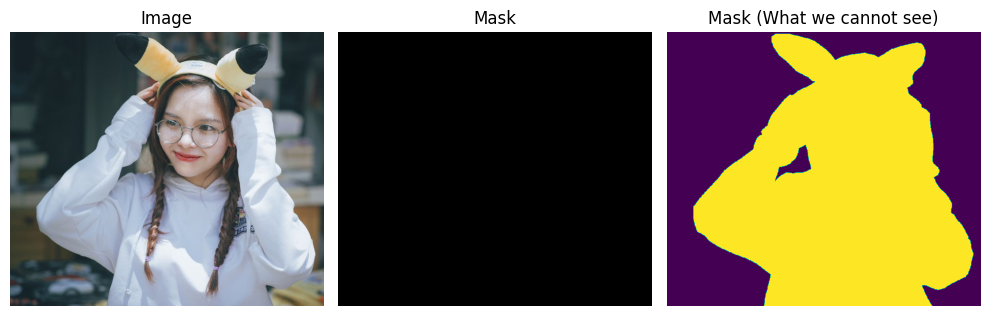

In [ ]:
# Create a figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(10, 10))

# Display the first image in the first subplot
axes[0].imshow(image)
axes[0].set_title('Image')
axes[0].axis('off')  # Turn off axis

# Display the second image in the second subplot
axes[1].imshow(mask, cmap=plt.get_cmap('gray'), vmin = 0, vmax = 255)
axes[1].set_title('Mask')
axes[1].axis('off')  # Turn off axis

# Display the second image in the second subplot
axes[2].imshow(mask)
axes[2].set_title('Mask (What we cannot see)')
axes[2].axis('off')  # Turn off axis

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

### **1.2. Going from pre-mask to post-mask**

For this preprocessing step we will be working in the `data_train_competition_raw` folder.

The first thing we need to do is to process the masks. In fact, what we need to do is to make all pixels related to people differently enough than the background in order to be able to detect contours, which are needed for the label generation. To do this we have used a script called `raw_masks_to_image_masks.py`, whose code is in the following code snippet.

*Note: The code snippet has been adapted from the one given in the lab statement*

In [ ]:
input_dir_train = '/content/data_train_competition_raw/masks_pre/train_split'
output_dir_train = '/content/data_train_competition_raw/masks_post/train_split'
input_dir_val = '/content/data_train_competition_raw/masks_pre/val_split'
output_dir_val = '/content/data_train_competition_raw/masks_post/val_split'
input_dir_test = '/content/data_train_competition_raw/masks_pre/test_split'
output_dir_test = '/content/data_train_competition_raw/masks_post/test_split'

# This allows for 10 persons #

palette: list[int] = [
        0, 0, 0, # For background -> Black
        255, 0, 0, # For persons -> Red
    ]

# We have to execute the processing loop three times: train, val and test
processes = (
    (input_dir_train, output_dir_train),
    (input_dir_val, output_dir_val),
    (input_dir_test, output_dir_test)
    )

for process in processes:

  input_dir = process[0]
  output_dir = process[1]

  for j in os.listdir(input_dir):
      if j == '.DS_Store':
        continue

      image_path = os.path.join(input_dir, j)
      mask = Image.open(image_path).convert('P')

      # Ensure that all non-zero values are set to 1
      mask_data = mask.load()
      width, height = mask.size
      for y in range(height):
          for x in range(width):
              if mask_data[x, y] > 0:
                  mask_data[x, y] = 1

      mask.putpalette(palette)
      save_path = os.path.join(output_dir, j)
      mask.save(save_path, 'PNG')

Once we have done this we can observe the obtained mask results, which have been stored in the `masks_post` folder.

In [ ]:
root_path = "/content/data_train_competition_raw/"

image_number = "549"

image_path_extension = "images/train/000" + image_number + ".jpg"
mask_pre_path_extension = "masks_pre/train/000" + image_number + ".png"
mask_post_path_extension = "masks_post/train/000" + image_number + ".png"

image_path = os.path.join(root_path, image_path_extension)
mask_pre_path = os.path.join(root_path, mask_pre_path_extension)
mask_post_path = os.path.join(root_path, mask_post_path_extension)

image = mpimg.imread(image_path)
mask_pre = mpimg.imread(mask_pre_path)
mask_post = mpimg.imread(mask_post_path)

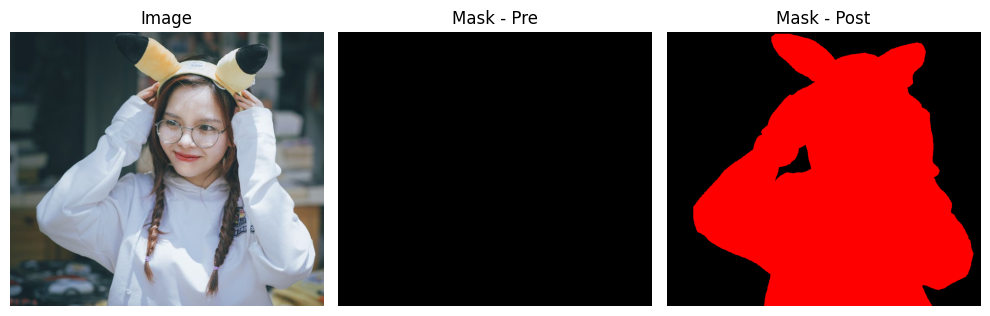

In [ ]:
# Create a figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(10, 10))

# Display the first image in the first subplot
axes[0].imshow(image)
axes[0].set_title('Image')
axes[0].axis('off')  # Turn off axis

# Display the second image in the second subplot
axes[1].imshow(mask_pre, cmap=plt.get_cmap('gray'), vmin = 0, vmax = 255)
axes[1].set_title('Mask - Pre')
axes[1].axis('off')  # Turn off axis

# Display the second image in the second subplot
axes[2].imshow(mask_post)
axes[2].set_title('Mask - Post')
axes[2].axis('off')  # Turn off axis

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

### **1.3. Going from post-mask to YOLO labels**

Once we have some distinguishable masks we are able to detect the contours. This is key for the processing, as yolo takes as inputs some labels which consist in different rows (one per each detected person) with the class label (which in our case will always be 0 as we only have the person class) and the contour points of the mask.

In order to generate these labels we have used the python script `masks_to_polygons.py`, whose code is in the following code snippet.

*Note: The code snippet has been extrated from the following source*

[Image segmentation with YoloV8 custom dataset | Computer Vision Tutorial](https://www.youtube.com/watch?v=aVKGjzAUHz0&t=1336s)

In [ ]:
input_dir_train = '/content/data_train_competition_raw/masks_post/train_split'
output_dir_train = '/content/data_train_competition_raw/labels/train_split'
input_dir_val = '/content/data_train_competition_raw/masks_post/val_split'
output_dir_val = '/content/data_train_competition_raw/labels/val_split'
input_dir_test = '/content/data_train_competition_raw/masks_post/test_split'
output_dir_test = '/content/data_train_competition_raw/labels/test_split'

# We have to execute the processing loop three times: train, val and test
processes = (
    (input_dir_train, output_dir_train),
    (input_dir_val, output_dir_val),
    (input_dir_test, output_dir_test)
    )

for process in processes:

  input_dir = process[0]
  output_dir = process[1]

  for j in os.listdir(input_dir):
      if j == '.DS_Store':
        continue

      image_path = os.path.join(input_dir, j)
      # load the binary mask and get its contours
      mask = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
      _, mask = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)

      H, W = mask.shape
      contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

      # convert the contours to polygons
      polygons = []
      for cnt in contours:
          if cv2.contourArea(cnt) > 200:
              polygon = []
              for point in cnt:
                  x, y = point[0]
                  polygon.append(x / W)
                  polygon.append(y / H)
              polygons.append(polygon)

      # print the polygons
      with open('{}.txt'.format(os.path.join(output_dir, j)[:-4]), 'w') as f:
          for polygon in polygons:
              for p_, p in enumerate(polygon):
                  if p_ == len(polygon) - 1:
                      f.write('{}\n'.format(p))
                  elif p_ == 0:
                      f.write('0 {} '.format(p))
                  else:
                      f.write('{} '.format(p))

          f.close()

Finally, to rename those masks of the *PennFudan* dataset we have used the following code.

In [ ]:
directories = [
    "/content/data_train_competition/labels/test_split/",
    "/content/data/data_train_competition/masks_pre/test_split/"
    "/content/data/data_train_competition/masks_post/test_split/"
    ]

for directory in directories:
  files = os.listdir(directory)

  # Print the files before renaming
  print("Files before renaming:")
  for filename in files:
      print(filename)

  # Loop through the files and rename them
  for filename in files:
      old_file = os.path.join(directory, filename)

      # Define the new file name (modify this as per your requirement)
      new_filename = old_file.split('/')[-1].replace('_mask.', '.')

      # Construct the new file path
      new_file = os.path.join(directory, new_filename)

      # Rename the file
      os.rename(old_file, new_file)

  # List all files in the directory after renaming
  renamed_files = os.listdir(directory)

  # Print the files after renaming
  print("Files after renaming:")
  for filename in renamed_files:
      print(filename)

  print("Files have been renamed successfully.")

## **2. YoloV8 fine-tuning**

At this point we have everything ready to work with the model. We will be using YoloV8 model (explanations are in the report). The idea is to first fine-tune the model's hyperparameters. Then we will be trying different experiments and evaluate them. After the evaluation we will see which model performs the best and, once this is done, we will train the final model by using the dataset with all the training data, including validation, during more epochs and then we will make the predictions.

For this section we will be using the `data_train_competition` folder. The one that already had the preprocessing done. However, the other one could be used as well.

### **2.0. Clearml**

In order to track our results, we will be using `clearml`. Accoording to their website, ClearML is an open source platform that automates and simplifies developing and managing machine learning solutions for thousands of data science teams all over the world.

Basically, we will be using this platform to track our result metrics as well as the used hyperparameters, download the best obtained weights for each experiment, see the training data that is fed into the model, etc.

### **2.1. Hyperparameter fine-tuning**

Throughout the next steps we will be using the medium version of the YoloV8 segmentation model. This has been decided by looking at the threshold between speed and performance (explanations in the report).

In [ ]:
model = YOLO('yolov8m-seg.pt')

100%|██████████| 52.4M/52.4M [00:00<00:00, 210MB/s]


In order to tune our hyperparameters we can use the `tune` method of the model. It works in an iterative way. This is, we start with some initial hyperparameters (which in our case are going to be the default ones) and in an iterative way the model is trained by updating the hyperparameters. At each training, we will be provided with the best hyperparameters (which can be obtained as well through clearml).

*Note: This has not been executed in google colab, as there are not enough resources to run it. As it is an iterative method, each hyperparmeter update takes the same time as a regular training, which makes it a considerably expensive technique. It has been executed in the Kaggle environment.*

In [ ]:
config_file_path = "/content/drive/MyDrive/PPSC-2024/Data/Config/config.yaml"

In [ ]:
model.tune(data = config_file_path, epochs = 8, imgsz = 640, name = "Hyps Tuning Second Version", iterations = 30)

Once this has been executed (which has already been in Kaggle), we are ready to train the following experiments.


1.   Fine tuning starting with YoloV8's weights
2.   Fine tuning starting with YoloV8's weights and freezing the backbone
3.   Fine tuning starting with YoloV8's weights and using the best hyperparameters found
4.   Fine tuning starting with YoloV8's weights, freezing the backbone and using the best hyperparameters found

The hyperparameters can be found in the `runs/segment` folder.


### **2.2. Training - First Experiment**

The configuration file, the one that contains information about the data paths and the classes, remains the same.

In [ ]:
model.train(data = config_file_path, epochs = 150, imgsz = 640, name = "Yolo Weights")

After this training we have obtained an mAP50:95 of **0.712**

### **2.3. Training - Second Experiment**

As before, the configuration file remains the same. However, we now intend to freeze the backbone. The backbone in YoloV8 consists of the first 12 layers of the model.

In [ ]:
model.train(data = config_file_path, epochs = 150, freeze = 12, imgsz = 640, name = "Yolo Weights - Freeze Backbone")

After this training we have obtained an mAP50:95 of **0.845**. We can observe a considerable improvement when freezing the backbone of the model.

### **2.4. Training - Third Experiment**

Once the best hyperparameters have been found we can now train the model with them. Again, the config file remains the same.

In [ ]:
cfg_file_path = "/content/drive/MyDrive/PPSC-2024/Data/Config/best_hyps.yaml"

In [ ]:
model.train(data = config_file_path, epochs = 150, imgsz = 640, cfg = cfg_file_path, name = "Yolo Weight - Hyps")

After this training we have obtained an mAP50:95 of **0.823**. We are increasing the performance of the model when using the hyperparameters. However, we get slightly worse results than when just freezing the backbone. Therefore, it might be interesting to combine both approaches, expecting to boost performance.

### **2.4. Training - Fourth Experiment**

In this experiment we will combine both freezing the backbone while using the best hyperparameters found. We expect this to be the best training in terms of mAP50:95. The same config file is used as well.

In [ ]:
model.train(data = config_file_path, epochs = 150, imgsz = 640, freeze = 12, cfg = cfg_file_path, name = "Yolo Weight - Hyps - Freeze Backbone")

After this training we have obtained an mAP50:95 of **0.857**. As we expected, the best results in terms of mAP50:95 are obtained with this experiment. When combining the best hyperparameters with the freezed backbone the model performs really well.

## **3. Model selection**

In order to choose the best model out of the previously explained, we will not only base in the mAP50:95 metric, but also in the mIoU obtained with our own `test` split, the one we generated. This is because, in the end, we will be evaluating our model by comparing the mIoU, so we must be sure that the best model performs well in this aspect as well.

To do so, we will iterate through the model while computing the mIoU for the test set. In this section we will leave the code for just one training. However, all paths will be evailable, so it is just a matter of selecting the one we want to test.

### **3.1. Generate predictions and postprocessing**

Now that we have our experimental models trained we can make the predictions with our test data. In order to do so, we have to generate the results image by image, so results fit in GPU memory. This forces us to implement the postprocessing in the same code cell.

The postprocessing cosists in the following. What YoloV8 does is, when an image is fed into the model, generate a predicted mask that is able to fit in a $640\times640$ square. However, the image will keep its ratio. This means that, for example, if we feed the model with a $100\times200$ image, the resulting mask will be $320\times640$.

Nonetheless, we expect our predicted masks to be the same shape than the ground truth masks, which are the same shape than the original images. Thus, we need to resize this images. This is what the postprocessing stage does. It takes the predicted mask and the associated image. Then, we retrieve the dimensions of the original image and resize the predicted mask to be that shape.

However, we need to take into account as well how YoloV8 structures masks. When more than one person is detected in the image, the model outputs as many masks as detected people. This results in a $(N,H,W)$-shaped tensor, where $N$ is the number of detected people. Therefore, to achieve a mask with all detected people together, we need to take the maximum value among the first dimension.

We finally set all values greater than zero to 255 in order to have a mask that can be visualized when displaying it (any value greater than zero would be enough for computing the IoU for that image, but this way we ensure that we can visualize the image.).

The first step is to obtain the paths to the images we want to predict.

In [ ]:
folder_path = "/content/data_train_competition/images/test_split/"

file_names = os.listdir(folder_path)
file_names = [folder_path + file for file in file_names if os.path.isfile(os.path.join(folder_path, file))]

In [ ]:
os.mkdir("/content/predictions_yolo_weights/")
os.mkdir("/content/predictions_yolo_weights_freeze/")
os.mkdir("/content/predictions_hyps/")
os.mkdir("/content/predictions_hyps_freeze/")

Then we just define the model with its corresponding weights.

In [ ]:
# Path to weights

yolo_weights_path = "/content/drive/MyDrive/PPSC-2024/Weights/best_weights_yolo.pt"
yolo_weigths_freeze_path = "/content/drive/MyDrive/PPSC-2024/Weights/best_weights_yolo_freeze.pt"
hyps_model_path = "/content/drive/MyDrive/PPSC-2024/Weights/best_weights_hyps.pt"
hyps_freeze_path = "/content/drive/MyDrive/PPSC-2024/Weights/best_weights_hyps_freeze.pt"

# Model definition and prediction
model = YOLO(hyps_model_path)

At this point we can already generate the predictions, while storing them in a folder.

In [ ]:
# Path to store predictions
predictions_path = "/content/predictions_hyps/"

for file in file_names:
  results = model(file)
  result = results[0]
  if hasattr(result, 'masks') and result.masks is not None:
    try:
      im = cv2.imread(file)
      true_mask = cv2.imread(file.replace('images', 'masks_post').replace('jpg', 'png'))

      H, W = im.shape[0], im.shape[1]

      tmp_mask = result.masks.data
      tmp_mask, _ = torch.max(tmp_mask, dim = 0)
      pred_mask = Image.fromarray(tmp_mask.cpu().numpy()).convert('P')
      pred_mask = pred_mask.resize((W, H))
      pred_mask = np.array(pred_mask)

      (width, height) = pred_mask.shape
      for y in range(height):
          for x in range(width):
              if pred_mask[x, y] > 0:
                  pred_mask[x, y] = 255

      im_to_save = Image.fromarray(pred_mask)
      im_to_save.save(predictions_path + file.split('/')[-1])
      file_name = file.split('/')[-1]
      print(f"Mask correctly processed and saved for the following file: {file_name}")
    except Exception as e:
      file_name = file.split('/')[-1]
      print(f'There has been an error while processing or saving the following file: {file_name}')
      print(f'The following error has occured: {e}')
  else:
    im = cv2.imread(file)
    H, W = im.shape[0], im.shape[1]
    pred_mask = np.zeros((H,W), dtype=np.uint8)
    im_to_save = Image.fromarray(pred_mask)
    im_to_save.save(predictions_path + file.split('/')[-1].replace('jpg', 'png'))
    file_name = file.split('/')[-1]
    print(f"Mask correctly processed and saved for the following file: {file_name}")


image 1/1 /content/data_train_competition/images/test_split/002512.jpg: 448x640 1 person, 34.3ms
Speed: 3.3ms preprocess, 34.3ms inference, 3.0ms postprocess per image at shape (1, 3, 448, 640)
Mask correctly processed and saved for the following file: 002512.jpg

image 1/1 /content/data_train_competition/images/test_split/002013.jpg: 448x640 1 person, 31.6ms
Speed: 3.2ms preprocess, 31.6ms inference, 2.9ms postprocess per image at shape (1, 3, 448, 640)
Mask correctly processed and saved for the following file: 002013.jpg

image 1/1 /content/data_train_competition/images/test_split/003755.jpg: 448x640 1 person, 38.9ms
Speed: 5.4ms preprocess, 38.9ms inference, 3.6ms postprocess per image at shape (1, 3, 448, 640)
Mask correctly processed and saved for the following file: 003755.jpg

image 1/1 /content/data_train_competition/images/test_split/005293.jpg: 480x640 2 persons, 35.5ms
Speed: 3.3ms preprocess, 35.5ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 640)
Mask corr

We can now an example.

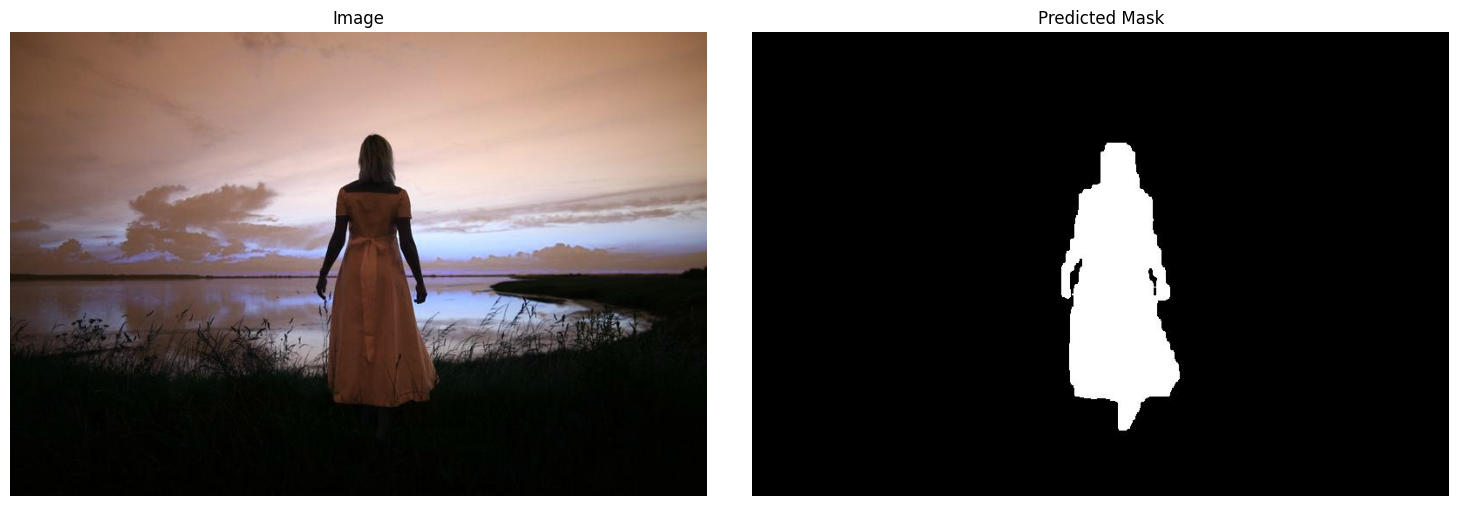

In [ ]:
idx_to_check = 100

im = cv2.imread(file_names[idx_to_check])
pred_mask = cv2.imread(predictions_path + file_names[idx_to_check].split('/')[-1], cv2.IMREAD_COLOR)

# Plot the images side by side using matplotlib
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].imshow(im)
axes[0].axis('off')  # Hide the axes
axes[0].set_title('Image')

axes[1].imshow(pred_mask)
axes[1].axis('off')  # Hide the axes
axes[1].set_title('Predicted Mask')

plt.tight_layout()
plt.show()

### **3.2. Computing the mIoU**

In [ ]:
mIoUs = {
    'yolo_weight':0,
    'yolo_weight_freeze':0,
    'best_hyps':0,
    'best_hyps_freeze':0
}

We will now compute the mIoU for our own test dataset in order to decide which model will be finally selected.

In [ ]:
mIoU = 0

for idx, file in enumerate(file_names):
  if
  try:
    file_name = file.split('/')[-1]
    true_mask = np.asarray(Image.open(file.replace('images', 'masks_post').replace('jpg', 'png')))
    pred_mask = np.asarray(Image.open(predictions_path + file_name))

    gtb = (true_mask > 0)
    predb = (pred_mask > 0)

    overlap = gtb * predb
    union = gtb + predb
    IoU = overlap.sum() / union.sum()

    print(f"{idx}. IoU for file {file_name} is: {IoU}")

    mIoU += IoU
  except Exception as e:
    print(f'Could not compute mIoU for file {file_name}')
    print(f'Error: {e}')

mIoU /= len(file_names)
print(f"Global mIoU = {mIoU:0.4f}")

0. IoU for file 002512.jpg is: 0.8513767352361754
1. IoU for file 002013.jpg is: 0.8737944421740907
2. IoU for file 003755.jpg is: 0.8877600572509329
3. IoU for file 005293.jpg is: 0.8361369483475163
4. IoU for file 004706.jpg is: 0.9087573817449366
5. IoU for file 003749.jpg is: 0.8953009982200257
6. IoU for file 001914.jpg is: 0.8872389476539192
7. IoU for file 002748.jpg is: 0.9099288224164339
8. IoU for file 003494.jpg is: 0.9188951170457115
9. IoU for file 002768.jpg is: 0.8539460336782309
10. IoU for file 003317.jpg is: 0.8968526020567155
11. IoU for file 003044.jpg is: 0.9605253688377114
12. IoU for file 002125.jpg is: 0.8616600565928384
13. IoU for file 003212.jpg is: 0.9113217293197311
14. IoU for file 004326.jpg is: 0.9557526030662891
15. IoU for file 002868.jpg is: 0.8657511020684978
16. IoU for file 001408.jpg is: 0.9440623072177668
17. IoU for file 000901.jpg is: 0.9035253756062936
18. IoU for file 004927.jpg is: 0.924388445223223
19. IoU for file 003415.jpg is: 0.76987516

In [ ]:
mIoUs['best_hyps'] = mIoU

These results have been obtained by executing several times for the several experiments the previous code.

In [ ]:
mIoUs

{'yolo_weight': 0.8352435358579982,
 'yolo_weight_freeze': 0.8748515224901751,
 'best_hyps': 0.8719346192682791,
 'best_hyps_freeze': 0.8773721501515972}

Out from this results and the mAP50:95, which has been obtained from the training executions (stated in the report), we can conclude that the best model is the one that uses the best found hyperparameters and fine-tunes YoloV8's pretrained weights while freezing the backbone of the model.

### **4. Definitive model**

We can now train the final model, the one chosen in the previous section, during more epochs. However, we will be using `patience = 50`, so the training might stop earlier.

In [ ]:
model.train(data = config_file_path, epochs = 300, imgsz = 640, freeze = 12, cfg = cfg_file_path, name = "Final Model")

Now that we have our model trained, we can evaluate the results in the validation dataset in terms of the mIoU, as we already have the results for the mAP50:95.

To test it we need to use another dataset, as we have merged the test and the training splits from the previous datasets to use all images for the training.

In [ ]:
!unzip -q "/content/drive/MyDrive/PPSC-2024/Data/data_final_train_competition.zip" -d "/content/data_final_train_competition"

In [ ]:
os.mkdir("/content/evaluation_final_model")

In [ ]:
folder_path = "/content/data_final_train_competition/data_train_competition/images/val_split/"

file_names = os.listdir(folder_path)
file_names = [folder_path + file for file in file_names if os.path.isfile(os.path.join(folder_path, file))]

In [ ]:
final_model_path = "/content/drive/MyDrive/PPSC-2024/Weights/best_definitive.pt"

model = YOLO(final_model_path)

In [ ]:
# Path to store predictions
predictions_path = "/content/evaluation_final_model/"

for file in file_names:
  if file.split('/')[-1] != ".DS_Store":
    results = model(file)
    result = results[0]
    if hasattr(result, 'masks') and result.masks is not None:
      try:
        im = cv2.imread(file)
        true_mask = cv2.imread(file.replace('images', 'masks_post').replace('jpg', 'png'))

        H, W = im.shape[0], im.shape[1]

        tmp_mask = result.masks.data
        tmp_mask, _ = torch.max(tmp_mask, dim = 0)
        pred_mask = Image.fromarray(tmp_mask.cpu().numpy()).convert('P')
        pred_mask = pred_mask.resize((W, H))
        pred_mask = np.array(pred_mask)

        (width, height) = pred_mask.shape
        for y in range(height):
            for x in range(width):
                if pred_mask[x, y] > 0:
                    pred_mask[x, y] = 255

        im_to_save = Image.fromarray(pred_mask)
        im_to_save.save(predictions_path + file.split('/')[-1])
        file_name = file.split('/')[-1]
        print(f"Mask correctly processed and saved for the following file: {file_name}")
      except Exception as e:
        file_name = file.split('/')[-1]
        print(f'There has been an error while processing or saving the following file: {file_name}')
        print(f'The following error has occured: {e}')
    else:
      im = cv2.imread(file)
      H, W = im.shape[0], im.shape[1]
      pred_mask = np.zeros((H,W), dtype=np.uint8)
      im_to_save = Image.fromarray(pred_mask)
      file_name_to_save = file.split('/')[-1].replace('jpg', 'png')
      im_to_save.save(predictions_path + file_name_to_save)
      file_name = file.split('/')[-1]
      print(f"Mask correctly processed and saved for the following file: {file_name}")


image 1/1 /content/data_final_train_competition/data_train_competition/images/val_split/001795.jpg: 448x640 1 person, 34.7ms
Speed: 3.1ms preprocess, 34.7ms inference, 3.2ms postprocess per image at shape (1, 3, 448, 640)
Mask correctly processed and saved for the following file: 001795.jpg

image 1/1 /content/data_final_train_competition/data_train_competition/images/val_split/001863.jpg: 640x448 1 person, 33.9ms
Speed: 2.2ms preprocess, 33.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 448)
Mask correctly processed and saved for the following file: 001863.jpg

image 1/1 /content/data_final_train_competition/data_train_competition/images/val_split/001667.jpg: 448x640 1 person, 34.1ms
Speed: 2.3ms preprocess, 34.1ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)
Mask correctly processed and saved for the following file: 001667.jpg

image 1/1 /content/data_final_train_competition/data_train_competition/images/val_split/001910.jpg: 256x640 1 person, 22

In [ ]:
mIoU = 0

for idx, file in enumerate(file_names):
  try:
    file_name = file.split('/')[-1]
    true_mask = np.asarray(Image.open(file.replace('images', 'masks_post').replace('jpg', 'png')))
    pred_mask = np.asarray(Image.open(predictions_path + file_name))

    gtb = (true_mask > 0)
    predb = (pred_mask > 0)

    overlap = gtb * predb
    union = gtb + predb
    IoU = overlap.sum() / union.sum()

    print(f"{idx}. IoU for file {file_name} is: {IoU}")

    mIoU += IoU
  except Exception as e:
    print(f'Could not compute mIoU for file {file_name}')
    print(f'Error: {e}')

mIoU /= len(file_names)
print(f"Global mIoU = {mIoU:0.4f}")

0. IoU for file 001795.jpg is: 0.9272199118833824
1. IoU for file 001863.jpg is: 0.856089617180443
2. IoU for file 001667.jpg is: 0.7580153779196286
3. IoU for file 001910.jpg is: 0.7923643054277829
4. IoU for file 001868.jpg is: 0.8178513446742429
5. IoU for file 003094.jpg is: 0.9287415162227654
6. IoU for file 002280.jpg is: 0.9749971550132338
7. IoU for file 003811.jpg is: 0.9516758494031221
8. IoU for file 003755.jpg is: 0.8885724502566984
9. IoU for file 005293.jpg is: 0.8238452858087864
10. IoU for file 003794.jpg is: 0.7972371710665707
11. IoU for file 004703.jpg is: 0.33310205626340356
12. IoU for file 004089.jpg is: 0.37049674596462845
13. IoU for file 001754.jpg is: 0.82811133780239
14. IoU for file 003494.jpg is: 0.9189024390243903
15. IoU for file 000739.jpg is: 0.9303807910377492
16. IoU for file 004973.jpg is: 0.8743179897026051
17. IoU for file 003599.jpg is: 0.9533987973883197
18. IoU for file 003970.jpg is: 0.7836822940373236
19. IoU for file 005041.jpg is: 0.91380420

### **5. Predictions**

We will now generate the predictions for the final dataset, the original test dataset.

In [ ]:
folder_path = "/content/data_train_competition/images/test/"

file_names = os.listdir(folder_path)
file_names = [folder_path + file for file in file_names if os.path.isfile(os.path.join(folder_path, file))]

In [ ]:
final_model_path = "/content/drive/MyDrive/PPSC-2024/Weights/best_definitive.pt"

model = YOLO(final_model_path)

In [ ]:
os.mkdir("/content/predictions/")

In [ ]:
# Path to store predictions
predictions_path = "/content/predictions/"

for file in file_names:
  if file.split('/')[-1] == ".DS_Store":
    continue

  results = model(file)
  result = results[0]
  if hasattr(result, 'masks') and result.masks is not None:
    try:
      im = cv2.imread(file)
      true_mask = cv2.imread(file.replace('images', 'masks_post').replace('jpg', 'png'))

      H, W = im.shape[0], im.shape[1]

      tmp_mask = result.masks.data
      tmp_mask, _ = torch.max(tmp_mask, dim = 0)
      pred_mask = Image.fromarray(tmp_mask.cpu().numpy()).convert('P')
      pred_mask = pred_mask.resize((W, H))
      pred_mask = np.array(pred_mask)

      (width, height) = pred_mask.shape
      for y in range(height):
          for x in range(width):
              if pred_mask[x, y] > 0:
                  pred_mask[x, y] = 255

      im_to_save = Image.fromarray(pred_mask)
      file_name_to_save = file.split('/')[-1].replace('jpg', 'png')
      path_to_save = predictions_path + file_name_to_save
      im_to_save.save(path_to_save)
      print(f"Mask correctly processed and saved for the following file: {file_name_to_save}")
    except Exception as e:
      file_name = file.split('/')[-1]
      print(f'There has been an error while processing or saving the following file: {file_name}')
      print(f'The following error has occured: {e}')
  else:
    im = cv2.imread(file)
    H, W = im.shape[0], im.shape[1]
    pred_mask = np.zeros((H,W), dtype=np.uint8)
    im_to_save = Image.fromarray(pred_mask)
    file_name_to_save = file.split('/')[-1].replace('jpg', 'png')
    path_to_save = predictions_path + file_name_to_save
    im_to_save.save(path_to_save)
    print(f"Mask correctly processed and saved for the following file: {file_name_to_save}")


image 1/1 /content/data_train_competition/images/test/100028.jpg: 448x640 1 person, 34.8ms
Speed: 3.5ms preprocess, 34.8ms inference, 3.3ms postprocess per image at shape (1, 3, 448, 640)
Mask correctly processed and saved for the following file: 100028.png

image 1/1 /content/data_train_competition/images/test/100055.jpg: 640x448 1 person, 33.9ms
Speed: 2.4ms preprocess, 33.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 448)
Mask correctly processed and saved for the following file: 100055.png

image 1/1 /content/data_train_competition/images/test/100078.jpg: 640x448 1 person, 32.9ms
Speed: 2.2ms preprocess, 32.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 448)
Mask correctly processed and saved for the following file: 100078.png

image 1/1 /content/data_train_competition/images/test/100143.jpg: 640x448 1 person, 32.9ms
Speed: 2.3ms preprocess, 32.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 448)
Mask correctly processed and saved

Now we can download the predictions by creating a zip and downloading it.

In [ ]:
!zip -r predictions.zip /content/predictions/

  adding: content/predictions/ (stored 0%)
  adding: content/predictions/100046.png (deflated 10%)
  adding: content/predictions/100075.png (deflated 12%)
  adding: content/predictions/100200.png (deflated 15%)
  adding: content/predictions/100466.png (deflated 16%)
  adding: content/predictions/100038.png (deflated 12%)
  adding: content/predictions/100357.png (deflated 19%)
  adding: content/predictions/100028.png (deflated 24%)
  adding: content/predictions/100373.png (deflated 16%)
  adding: content/predictions/100343.png (deflated 14%)
  adding: content/predictions/100123.png (deflated 18%)
  adding: content/predictions/100400.png (deflated 12%)
  adding: content/predictions/100132.png (deflated 14%)
  adding: content/predictions/100276.png (deflated 7%)
  adding: content/predictions/100181.png (deflated 16%)
  adding: content/predictions/100079.png (deflated 13%)
  adding: content/predictions/100246.png (deflated 17%)
  adding: content/predictions/100026.png (deflated 10%)
  addi

We can now visualize some examples.

*Note: Here the name of the predictions folder changes because we have downloaded and uploaded again by using Google Drive with the name already changed.*

In [ ]:
!unzip -q "/content/drive/MyDrive/PPSC-2024/Predictions/G11_E08.zip" -d "/content/"

In [ ]:
folder_path = "/content/data_train_competition/images/test/"

file_names = os.listdir(folder_path)
file_names = [folder_path + file for file in file_names if os.path.isfile(os.path.join(folder_path, file))]

In [ ]:
file_names.index('/content/data_train_competition/images/test/100000.jpg')

185

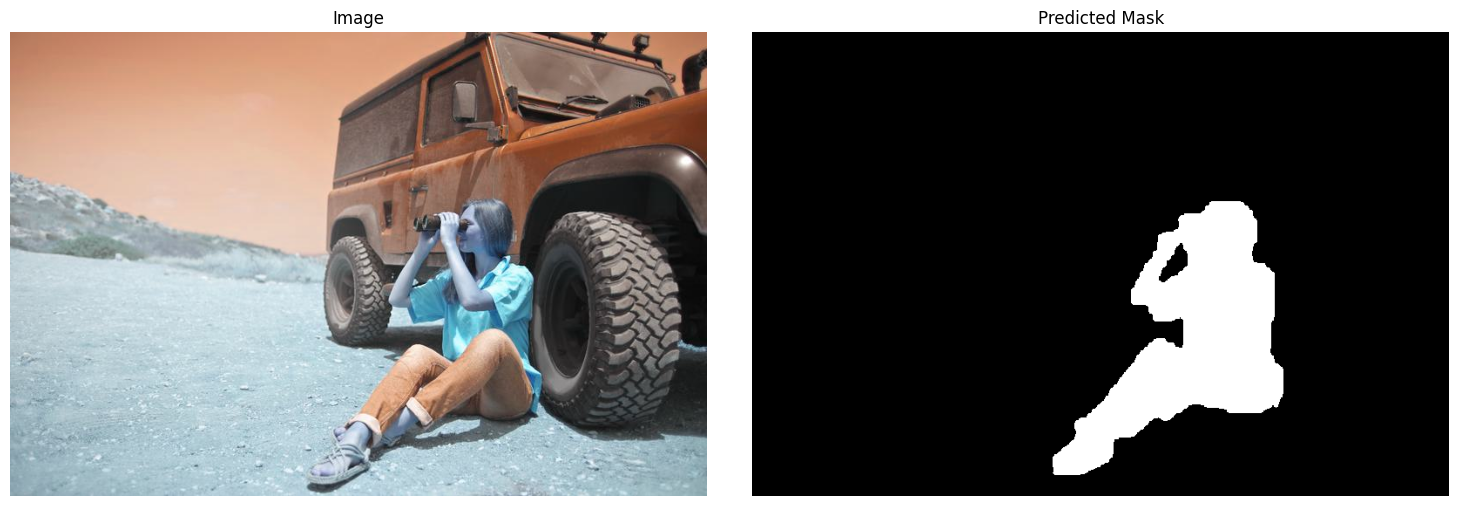

In [ ]:
idx_to_check = 6

im = cv2.imread(file_names[idx_to_check], cv2.COLOR_BGR2RGB)
pred_mask = cv2.imread("/content/G11_E08/" + file_names[idx_to_check].split('/')[-1].replace('jpg', 'png'), cv2.IMREAD_COLOR)

# Plot the images side by side using matplotlib
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].imshow(np.array(im))
axes[0].axis('off')  # Hide the axes
axes[0].set_title('Image')

axes[1].imshow(np.array(pred_mask))
axes[1].axis('off')  # Hide the axes
axes[1].set_title('Predicted Mask')

plt.tight_layout()
plt.show()

### **6. Verifying predictions format**

We will now verify that our predictions' format is correct for the submission.

In [ ]:
import shutil
import random

In [ ]:
# Make sure to change this for the path of the "dataset_person/test" folder and your group/team name
ZIPFILE = 'G11_E08'
TEST_FOLDER = "/content/dataset_person/test/"

In [ ]:
!unzip -q "/content/drive/MyDrive/PPSC-2024/dataset_person.zip" -d "/content/"

In [ ]:
# Sample script to compute mean IoU of predictions in the TEST. MANDATORY to check this on your file before the submission

# unzip the file into a tmp folder
os.makedirs(os.path.join(TEST_FOLDER,'tmp'))
shutil.unpack_archive(ZIPFILE + '.zip',os.path.join(TEST_FOLDER,'tmp'))

# Use a seed to control random generation
r = random.Random(7)

mIoU = 0.0

for cnt,f in enumerate(open(os.path.join(TEST_FOLDER,'test_names.txt'),'r')):

    b = f.strip()

    # read test image (we do not needed it but here we will use it to get the size of GT)
    im = Image.open(os.path.join(TEST_FOLDER,'images',b)+'.jpg')

    # read GT image (as a test we can generate the fake predictions)
    #gt = np.asarray(Image.open(os.path.join(TEST_FOLDER,'masks',b)+'.png'))
    gt = np.zeros((im.height,im.width),np.uint8)
    for o in range(r.randint(1,3)):
        sx = r.randint(im.width//8,im.width//2)
        x = r.randint(0,im.width-sx)
        sy = r.randint(im.height//8,im.height//2)
        y = r.randint(0,im.height-sy)
        gt[y:y+sy,x:x+sx] = o+1
    gtb = (gt>0) # we'll consider a global IoU for all objects

    # read prediction image
    pred = np.asarray(Image.open(os.path.join(TEST_FOLDER,'tmp',b)+'.png'))
    predb = (pred>0) # we'll consider a global IoU for all objects

    # Compute the global IoU in the image
    overlap = gtb * predb
    union   = gtb + predb
    IoU = overlap.sum()/union.sum()

    mIoU += IoU

# Report results
mIoU = mIoU / (cnt+1)
print(f"mIoU = {mIoU:0.4f}")

mIoU = 0.1524
